The denormalized ride start/stop points are horribly imprecise. I had assumed
they are the actual station locations, but now I wonder if they
are user locations when they start/stop on the app. The per-station location
imprecision is as big as the between-station distances.

So far I haven't trusted the over-time stability of station ids names and locations.
But in this notebook we'll use the GBFS station info feed as our reference
and try to impute those as the canonical station locations.

In [1]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import contextily as cx
from shapely import to_wkb


from data.constants import (LOCAL_CRS, WORLD_CRS, WEB_CRS)
from data.geo import foot_to_mi

In [2]:
bike_rides_in = "../data/raw/bike_rides.geoparquet"
bike_stations_in = "../data/interim/bike_stations_gbfs.geoparquet"

bike_rides_out = "../data/interim/bike_rides.geoparquet"

In [3]:
TOLERANCE = .25  # mi

# Pipeline in

In [4]:
bike_rides = gpd.read_parquet(bike_rides_in)
bike_stations = gpd.read_parquet(bike_stations_in)

# Preprocess

In [5]:
# no missing ids in rides data
assert bike_rides.station_name.notna().all()
assert bike_rides.station_id.notna().all()

# Merge to Station

In [6]:
# Get all possible matches
on_id_name = bike_rides.merge(bike_stations, on=['station_id','station_name'], how='left', indicator=True)
on_name = bike_rides.merge(bike_stations, on=['station_name'], how='left', indicator=True)
on_id = bike_rides.merge(bike_stations, on=['station_id'], how='left', indicator=True)

In [7]:
# Lengths match because merge keys are unique on right frame
assert len(on_id_name) == len(bike_rides) and len(on_id) == len(bike_rides) and len(on_name) == len(bike_rides)

In [8]:
# Prioritize PK, then name, then id.
id_name_mask = (on_id_name._merge == 'both')
name_mask = (on_id_name._merge == 'left_only') & (on_name._merge == 'both')
id_mask = (on_id_name._merge == 'left_only') & (on_id._merge == 'both')

In [9]:
# This reduces the number of possible duplicates greatly
sum(id_name_mask), sum(name_mask), sum(id_mask), sum(id_name_mask) + sum(name_mask) +  sum(id_mask), len(bike_rides)

(1012209, 67418, 2936, 1082563, 1086145)

In [10]:
# Remove spatial outliers
def margin(df):
    left = df['geometry_x'].to_crs(LOCAL_CRS)
    right = df['geometry_y'].to_crs(LOCAL_CRS)
    return left.distance(right).apply(foot_to_mi)

id_name_mask &= on_id_name.pipe(margin) <= TOLERANCE
name_mask &= on_name.pipe(margin) <= TOLERANCE
id_mask &= on_id.pipe(margin) <= TOLERANCE

In [11]:
# Check number of matches now
sum(id_name_mask), sum(name_mask), sum(id_mask), sum(id_name_mask) + sum(name_mask) +  sum(id_mask), len(bike_rides)

(1009065, 67418, 1816, 1078299, 1086145)

In [12]:
# We can concatenate without duplications
assert not (id_name_mask & name_mask).any()
assert not (id_name_mask & id_mask).any()
assert not (name_mask & id_mask).any()

# Spatial Merge

In [13]:
# Defined as rows that failed to match on name + location or id + location
not_merged = bike_rides.loc[~(id_name_mask | name_mask | id_mask)]

In [14]:
# Let's see if we want to match them on just location.
on_geom = not_merged.to_crs(LOCAL_CRS).sjoin_nearest(bike_stations.to_crs(LOCAL_CRS), 
                                                        how='left', lsuffix='x', rsuffix='y', 
                                                        distance_col='margin')
on_geom = on_geom[on_geom['margin'].apply(foot_to_mi) <= TOLERANCE]
on_geom = on_geom.to_crs(WORLD_CRS)
on_geom = on_geom.merge(bike_stations[['geometry']], how='left', left_on='index_y', right_index=True, suffixes=('','_imputed'))

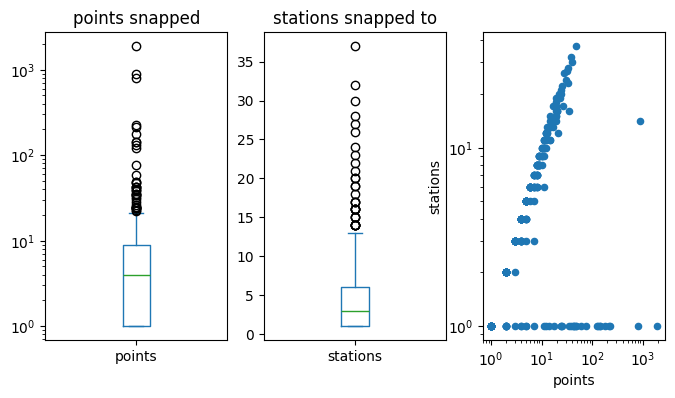

In [15]:
# First we see that a few outlier stations contribute the majority of uncertain points.
# Second we see that most stations snap to a wide distribution of other stations.
# Third we see two classes of original stations:
#   - ones that snap to a single station ==> schema drift
#   - ones that snap to multiple stations ==> ??
figs, axs = plt.subplots(1,3, figsize=(8,4))
plot_data = on_geom.groupby('station_name_x').size().rename('points')
plot_data.plot(kind='box', title='points snapped', ax=axs[0], logy=True);
plot_data2 = on_geom.groupby('station_name_x')['station_name_y'].nunique().rename('stations')
plot_data2.plot(kind='box', title='stations snapped to', ax=axs[1]);
plot_data3 = pd.concat([plot_data, plot_data2], axis=1)
plot_data3.plot(kind='scatter', x='points', y='stations', ax=axs[2], loglog=True);

In [16]:
geom_mask = on_geom.groupby('station_name_x')['station_name_y'].transform('nunique') == 1
on_geom_drop = on_geom[~geom_mask]
print("Reovered {} rows. May drop {} rows".format(sum(geom_mask), sum(~geom_mask)))

Reovered 4537 rows. May drop 2916 rows


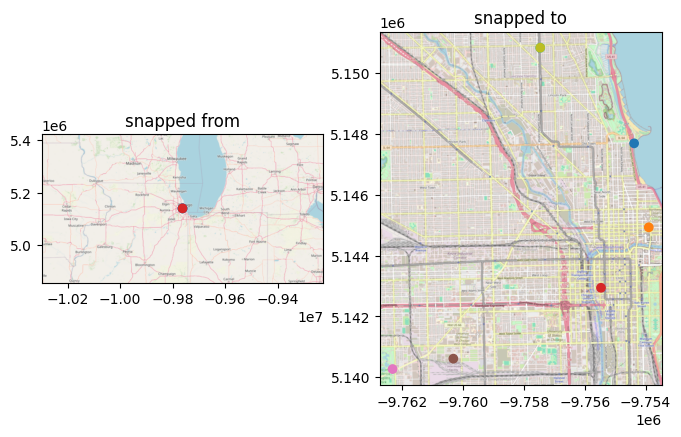

In [17]:
# To illustrate, we plot all points that snapped to 5 random station location.
# Colored by the original station name they purportedly belong to.
# We see original station names snapping to places very far apart.
figs, axs = plt.subplots(1,2, figsize=(8,6))
sample = on_geom_drop.station_name_y.sample(1)
plot_data = on_geom_drop[on_geom_drop.station_name_y.isin(sample)]
plot_data.to_crs(WEB_CRS).plot('station_name_x',ax=axs[0])
axs[0].set_title("snapped from")
cx.add_basemap(ax=axs[0], attribution=False)

# Another illustration, we take a single original station name and plot its
# original points, colored by the station they snap to. Shows how imprecise 
# this tail end of the data is.
sample = on_geom_drop.station_name_x.sample(1)
plot_data2 = on_geom_drop[on_geom_drop.station_name_x.isin(sample)]
plot_data2.to_crs(WEB_CRS).plot('station_name_y',ax=axs[1])
axs[1].set_title("snapped to")
cx.add_basemap(ax=axs[1], attribution=False)

# Collect Merged Points

In [18]:
on_id_name = on_id_name[id_name_mask]
on_name = on_name[name_mask].rename(columns={'station_id_x':'station_id',
                                            'station_id_y':'station_id_imputed'})
on_id = on_id[id_mask].rename(columns={'station_name_x':'station_name',
                                        'station_name_y':'station_name_imputed'})
on_attr = (pd.concat([on_id_name, on_name, on_id])
          .drop(columns=['_merge'])
          .rename(columns={'geometry_x':'geometry',
                           'geometry_y':'geometry_imputed'}))

on_geom = (on_geom[geom_mask]
            .drop(columns=['index_y','margin'])
            .rename(columns={'station_id_x':'station_id',
                            'station_id_y':'station_id_imputed',
                            'station_name_x':'station_name',
                            'station_name_y':'station_name_imputed'}))

merged = pd.concat([on_attr, on_geom]) 

In [19]:
# Since this is only a fraction of a percent of rides, I think its ok to drop it.
not_merged = bike_rides.loc[~(id_name_mask | name_mask | id_mask | geom_mask)]
bad_data_count = not_merged.filter(like='ride').assign(n=1).sum()
all_data_count = bike_rides.filter(like='ride').assign(n=1).sum()
bad_data_count / all_data_count

start_rides    0.006431
end_rides      0.005712
rides          0.006073
n              0.003049
dtype: float64

# Pipeline out

In [20]:
assert all(merged.station_name.notna() | merged.station_name_imputed.notna())
assert all(merged.station_id.notna() | merged.station_id_imputed.notna())
assert all(merged.geometry.notna() | merged.geometry_imputed.notna())

In [21]:
assert merged.geometry_imputed.notna().all()

In [22]:
merged = merged.assign(geometry_imputed = merged.geometry_imputed.apply(to_wkb))

In [23]:
merged.to_parquet(bike_rides_out, index=False)